<a href="https://colab.research.google.com/github/julvc/python_diplo/blob/master/MP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproyecto 2: Machine Learning con Valor
#### **Curso:** Introducción a Minería de Datos y Machine Learning

---

**¡Felicidades por tu excelente trabajo en el MP1!**

Tu labor en el preprocesamiento de la base de datos ha causado un gran impacto en **AMAZOFF**.

El equipo de Customer Experience ha quedado impresionado con tu habilidad para transformar datos sucios en información
útil y ahora quieren aprovechar tus talentos para enfrentar un nuevo desafío.

Nos han pedido desarrollar un **Predictor de Ratings de Pedidos** utilizando los datos preprocesados de ratings de
pedidos de nuestra plataforma de e-commerce.

# Pauta de Evaluación

Este MP2 está enfocado en responder preguntas de negocio relevantes para **AMAZOFF**.

### Preguntas de Negocio

1. (15 puntos) El equipo necesita extraer la máxima información de los datos. ¿Cómo modificarías la base de datos para ser usada con modelos de ML?
2. (15 puntos) ¡Wow! Gran *feature engineering*. Toca armar tu set para entrenar el modelo. ¿Podrías generar gráficas para el equipo de Customer Experience que expliquen mejor los datos nuevos? ¡No olvides explicarlas!
3. (10 puntos) Dicen que se pueden encontrar patrones en tus datos de entrenamiento. ¿Qué patrones encuentras en los pedidos? ¿Cómo pueden ser de utilidad para mejorar las ventas de AMAZOFF?
4. (25 puntos) ¡Viva el ML! Toca predecir la satisfacción del cliente. ¿Es posible predecir bien el `rating_class`?
5. (20 puntos) El equipo de Customer Experience dice que un solo modelo no es suficiente. ¿Podrías implementar otro?
6. (15 puntos) ¡Dos modelos! Eso es genial. ¿Qué modelo funcionó peor? ¿Si utilizas PCA podría mejor?

### Tener en consideración:

En caso de que el código esté bien, pero no se responda (usando celdas de texto) la pregunta de negocio (sección **Explicación**), **se asignará máximo la mitad de puntos** de esa pregunta.

El miniproyecto está diseñado para completar código. Suba el notebook solo con el código para responder la pregunta de negocio.

> # ¡NO OLVIDES GUARDAR Y SUBIR EL NOTEBOOK A LA PLATAFORMA CUANDO TERMINES! FORMATO .ipynb

# Preámbulo

**¡Cuidado!** En esta sección solo puedes modificar la sección de PÁRAMETROS.

In [1]:
# ¡No modificar esta celda! No está permitido usar librerías adicionales.

# Association Rules
from mlxtend.frequent_patterns import apriori, association_rules

# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# General Data Science
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Esta configuración permite que los dataframes se muestren completos.
import warnings ; warnings.warn = lambda *args,**kwargs: None
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# PARÁMETROS (puedes modificar esta sección)

DATA_PATH = 'ecommerce.csv' # Si tienes el archivo en otro lugar, cámbialo.
RANDOM_STATE = 0 # ¡Cámbialo a tu número favorito!

In [4]:
# ¡No modificar! Esta celda se encarga de cargar los datos.
df = pd.read_csv(DATA_PATH)
df.purchased = pd.to_datetime(df.purchased)
df.delivered = pd.to_datetime(df.delivered)
df.estimated_delivery = pd.to_datetime(df.estimated_delivery)
print(f'{df.shape[0]} rows x {df.shape[1]} columns')
df.head(5)

63606 rows x 14 columns


,order,product,seller,customer,city,state,category,price,shipping,payment,purchased,delivered,estimated_delivery,rating
0,0,0,0,0,unknown,SP,health,223.51,84.65,credit card,2017-10-22 18:57:54,2017-10-26 22:19:52,2017-11-09 12:00:00,1.0
1,1,1,1,1,unknown,RJ,health,170.80,23.79,credit card,2018-06-20 21:40:31,2018-07-03 22:51:22,2018-07-24 12:00:00,4.5
2,2,2,2,2,unknown,SP,technology,64.40,17.38,credit card,2018-02-16 16:19:31,2018-02-27 01:29:50,2018-03-08 12:00:00,3.5
3,3,1,3,3,uberlandia,MG,technology,264.50,30.72,credit card,2018-08-18 18:04:29,2018-08-27 20:03:51,2018-09-19 12:00:00,3.0
4,4,3,4,4,unknown,SP,technology,779.90,30.66,credit card,2017-12-22 16:44:04,2018-01-05 19:22:49,2018-01-18 12:00:00,2.5


In [5]:
# ¿Cuántos valores únicos hay en cada columna?
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values')

order: 63606 unique values
product: 18 unique values
seller: 25 unique values
customer: 63606 unique values
city: 26 unique values
state: 5 unique values
category: 5 unique values
price: 4433 unique values
shipping: 4849 unique values
payment: 2 unique values
purchased: 53475 unique values
delivered: 53496 unique values
estimated_delivery: 433 unique values
rating: 9 unique values


# 1. El equipo necesita extraer la máxima información de los datos. ¿Cómo modificarías la base de datos para ser usada con modelos de ML?

⁉️ **Consideración:** La última celda de esta sección es la de cálculo de `rating_class`, mantener el orden. Agregar las celdas para modificar
los datos, antes de esta. No olvides modificar el código para calcular la clase de rating.

ℹ️ **HINT:** Utiliza una celda para cada columna. ¿Qué columnas no sirven? ¿Qué columnas necesito que sean números? ¿Nuevas columnas?

📖 **Referencia Externa:** [Feature Engineering](https://www.freecodecamp.org/news/feature-engineering-techniques-for-structured-data/).

---

✅ **Explicación:**

- Cree columnas para City y State, para poder identificar las de mayor "busqueda" y las que poseen menor cantidad de registros dejarlas en otra como columna. Para City solo considere los 3 mayores busquedas. Para State escogi las de SP y RJ, para que el resto sea como other

- Para las siguientes columnas solo se considera el top de valores para seller, products y category. Esto hara que marque 1 para esos filas en las columnas mencionadas que cumplan esa caracteristica.


In [6]:
# [ COLUMNAS PARA CITY Y STATE]
df['is_unknown_city'] = (df['city'] == 'unknown').astype(int)
df['is_sao_paulo_city'] = (df['city'] == 'sao paulo').astype(int)
df['is_rio_de_janeiro_city'] = (df['city'] == 'rio de janeiro').astype(int)

df['is_sp_state'] = (df['state'] == 'SP').astype(int)
df['is_rj_state'] = (df['state'] == 'RJ').astype(int)
df['is_other_state'] = df["state"].apply(lambda x: 1 if x in ['MG', 'RS', 'PR'] else 0)
df.head(5)

,order,product,seller,customer,city,state,category,price,shipping,payment,purchased,delivered,estimated_delivery,rating,is_unknown_city,is_sao_paulo_city,is_rio_de_janeiro_city,is_sp_state,is_rj_state,is_other_state
0,0,0,0,0,unknown,SP,health,223.51,84.65,credit card,2017-10-22 18:57:54,2017-10-26 22:19:52,2017-11-09 12:00:00,1.0,1,0,0,1,0,0
1,1,1,1,1,unknown,RJ,health,170.80,23.79,credit card,2018-06-20 21:40:31,2018-07-03 22:51:22,2018-07-24 12:00:00,4.5,1,0,0,0,1,0
2,2,2,2,2,unknown,SP,technology,64.40,17.38,credit card,2018-02-16 16:19:31,2018-02-27 01:29:50,2018-03-08 12:00:00,3.5,1,0,0,1,0,0
3,3,1,3,3,uberlandia,MG,technology,264.50,30.72,credit card,2018-08-18 18:04:29,2018-08-27 20:03:51,2018-09-19 12:00:00,3.0,0,0,0,0,0,1
4,4,3,4,4,unknown,SP,technology,779.90,30.66,credit card,2017-12-22 16:44:04,2018-01-05 19:22:49,2018-01-18 12:00:00,2.5,1,0,0,1,0,0


In [7]:
# [ COLUMNAS TOPS PRODUCT Y SELLER ]
top_products = df['product'].value_counts().head(3).index.to_list()
df['is_top_product'] = df['product'].isin(top_products).astype(int)
top_sellers = df['seller'].value_counts().head(3).index.to_list()
df['is_top_seller'] = df['seller'].isin(top_sellers).astype(int)
df['is_credit_card'] = (df['payment'] == 'credit card').astype(int)
df.head(5)

,order,product,seller,customer,city,state,category,price,shipping,payment,purchased,delivered,estimated_delivery,rating,is_unknown_city,is_sao_paulo_city,is_rio_de_janeiro_city,is_sp_state,is_rj_state,is_other_state,is_top_product,is_top_seller,is_credit_card
0,0,0,0,0,unknown,SP,health,223.51,84.65,credit card,2017-10-22 18:57:54,2017-10-26 22:19:52,2017-11-09 12:00:00,1.0,1,0,0,1,0,0,1,0,1
1,1,1,1,1,unknown,RJ,health,170.80,23.79,credit card,2018-06-20 21:40:31,2018-07-03 22:51:22,2018-07-24 12:00:00,4.5,1,0,0,0,1,0,1,1,1
2,2,2,2,2,unknown,SP,technology,64.40,17.38,credit card,2018-02-16 16:19:31,2018-02-27 01:29:50,2018-03-08 12:00:00,3.5,1,0,0,1,0,0,0,0,1
3,3,1,3,3,uberlandia,MG,technology,264.50,30.72,credit card,2018-08-18 18:04:29,2018-08-27 20:03:51,2018-09-19 12:00:00,3.0,0,0,0,0,0,1,1,0,1
4,4,3,4,4,unknown,SP,technology,779.90,30.66,credit card,2017-12-22 16:44:04,2018-01-05 19:22:49,2018-01-18 12:00:00,2.5,1,0,0,1,0,0,0,0,1


In [8]:
# [ COLUMNA TOP CATEGORY ]
top_category = df['category'].value_counts().head(3).index.to_list()
df['is_top_category'] = df['category'].isin(top_category).astype(int)
df.head(5)

,order,product,seller,customer,city,state,category,price,shipping,payment,purchased,delivered,estimated_delivery,rating,is_unknown_city,is_sao_paulo_city,is_rio_de_janeiro_city,is_sp_state,is_rj_state,is_other_state,is_top_product,is_top_seller,is_credit_card,is_top_category
0,0,0,0,0,unknown,SP,health,223.51,84.65,credit card,2017-10-22 18:57:54,2017-10-26 22:19:52,2017-11-09 12:00:00,1.0,1,0,0,1,0,0,1,0,1,0
1,1,1,1,1,unknown,RJ,health,170.80,23.79,credit card,2018-06-20 21:40:31,2018-07-03 22:51:22,2018-07-24 12:00:00,4.5,1,0,0,0,1,0,1,1,1,0
2,2,2,2,2,unknown,SP,technology,64.40,17.38,credit card,2018-02-16 16:19:31,2018-02-27 01:29:50,2018-03-08 12:00:00,3.5,1,0,0,1,0,0,0,0,1,1
3,3,1,3,3,uberlandia,MG,technology,264.50,30.72,credit card,2018-08-18 18:04:29,2018-08-27 20:03:51,2018-09-19 12:00:00,3.0,0,0,0,0,0,1,1,0,1,1
4,4,3,4,4,unknown,SP,technology,779.90,30.66,credit card,2017-12-22 16:44:04,2018-01-05 19:22:49,2018-01-18 12:00:00,2.5,1,0,0,1,0,0,0,0,1,1


Debido a que estaremos realizando clasificación, pasaremos `rating`de numérico a categórico. Deberás modificar `RATING_BINS`
y `RATING_LABELS` para seleccionar cómo realizar el *binning* de esta clase.

**Ejemplo:**
```python
    RATING_BINS = [0, 2, 3.5, 5]
    RATING_LABELS = ['low', 'medium', 'high']
```

In [9]:
# Modifica RATING_BINS y RATING_LABELS según consideres.
RATING_BINS = [0,2,3.7,5]
RATING_LABELS = ['low', 'medium', 'high']

################################################################################

# ¡No modificar! Este código se encarga de crear la columna rating_class.
df['rating_class'] = pd.cut(df['rating'], bins=RATING_BINS, labels=RATING_LABELS, include_lowest=True)
df.value_counts(['rating', 'rating_class'], normalize=True, sort=False, dropna=False)

,,proportion
rating,rating_class,
1.0,low,0.262617
1.5,low,0.062934
2.0,low,0.118322
2.5,medium,0.077744
3.0,medium,0.137770
3.5,medium,0.081046
4.0,high,0.045389
4.5,high,0.124013
5.0,high,0.090164


**¡Ten cuidado!** Debes intentar que tus `rating_class` no sean demasiado imbalancedas. Por ejemplo, que el 90% de los datos
sean *low*, 5% *medium* y 5% *high*. Es preferible algo como: 40% *low*, 30% *medium* y 30% *high*.

In [10]:
# ¡No modificar!
df.value_counts('rating_class', normalize=True, sort=False, dropna=False)

,proportion
rating_class,
low,0.443873
medium,0.296560
high,0.259567


# 2. ¡Wow! Gran *feature engineering*. Toca armar tu set para entrenar el modelo. ¿Podrías generar gráficas para el equipo de Customer Experience que expliquen mejor los datos nuevos? ¡No olvides explicarlas!

⁉️ **Consideración:** Modifica la lista de columnas a eliminar para el *train*. Debes de hacer por lo menos dos gráficos.

ℹ️ **HINT 1:** ¿Por qué tus gráficas aportan al equipo de Customer Experience? ¡Explica tus nuevas columnas! ¿No tienes? 😓

ℹ️ **HINT 2:** Un buen gráfico tiene título, *labels*, leyenda... ¡y mucho más!

📖 **Referencia Externa:** [Tutorial de Seaborn](https://www.datacamp.com/tutorial/seaborn-python-tutorial).

---

✅ **Explicación:**

- **Gráfico 1:** Es importante saber si los productos comprados (incluyendo producto y envio) influye o no en el rating. Segun los datos al parecer a productos y envios con alto precio suelen ser marcados con un rating alto lo cual puede dar pistar para crear mejores promociones o bien presentar productos con un alto nivel porque de seguro daran un buen rating.

- **Gráfico 2:** El saber exactamente cuantos dias se demora realmente la entrega ordenados por rating da ha entender que el maximo de dias para entrega es 10, ya pasando esta fecha solo obtendremos un rating bajo sin importar el precio alto pagado. Sirve tambien para tomar y mejorar decisiones en el envio y despacho y bajar la cantidad de dias para entregar el product.

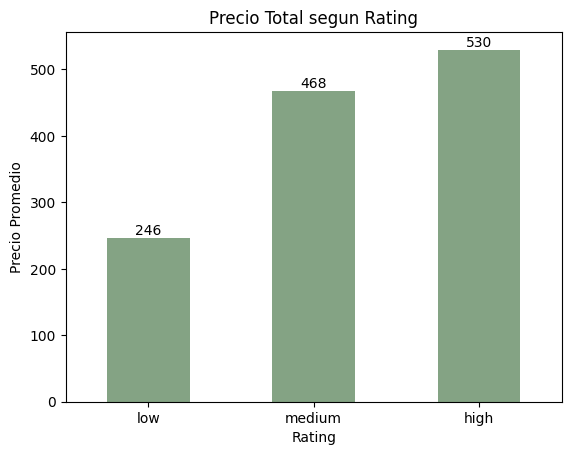

In [12]:
# Gráfico 1: [ Precio Total segun Rating Class ]

########################################################################################################################
color = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         )
df['total_price'] = df['price']+df['shipping']
total_price_mean = df.groupby('rating_class')['total_price'].mean()
total_price_mean.plot(kind='bar',color=color)
for i, v in enumerate(total_price_mean):
    plt.text(i, v, str(round(v)), ha='center', va='bottom')



plt.xlabel('Rating')
plt.ylabel('Precio Promedio')
plt.title('Precio Total segun Rating')
plt.xticks(ticks=range(len(total_price_mean.index)), labels=total_price_mean.index, rotation=0, ha='center')
plt.show()


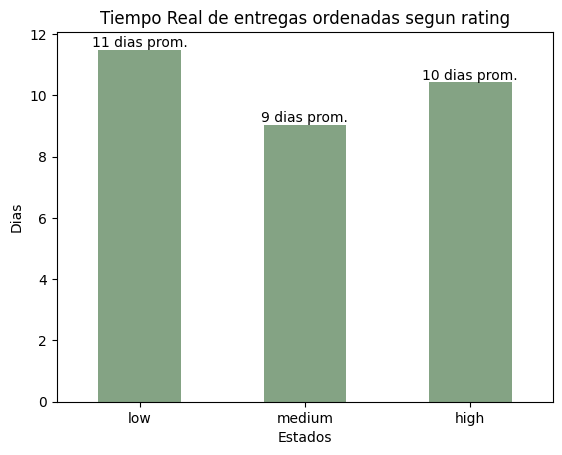

In [13]:
# Gráfico 2: [ Tiempo Real de entregas segun Estados ]

########################################################################################################################
df['real_delivery_in_days'] = abs(df['purchased'] - df['delivered']).dt.days
mean_delivery_times = df.groupby('rating_class')['real_delivery_in_days'].mean()
mean_delivery_times.plot(kind='bar',color=color)
for i, v in enumerate(mean_delivery_times):
    plt.text(i, v, str(round(v)) + ' dias prom.', ha='center', va='bottom')

plt.xlabel('Estados')
plt.ylabel('Dias')
plt.title('Tiempo Real de entregas ordenadas segun rating')
plt.xticks(ticks=range(len(mean_delivery_times.index)), labels=mean_delivery_times.index, rotation=0, ha='center')
plt.show()

In [ ]:
# Modifica la lista de columnas a eliminar según consideres.

x = df.drop(
    columns=[
        'order', 'product', 'seller', 'customer', 'category', 'city', 'state', 'purchased', 'delivered', 'estimated_delivery',
        'price', 'shipping', 'total_price', 'shipping', 'payment', 'purchased', 'delivered', 'estimated_delivery',
        'rating', 'rating_class'
    ]
)

########################################################################################################################

# ¡No modificar! Esta celda se encarga de dividir los datos en conjuntos de entrenamiento, validación y prueba.

y = df['rating_class']

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

print(f'Train: {x_train.shape[0]} rows')
print(f'Validation: {x_val.shape[0]} rows')
print(f'Test: {x_test.shape[0]} rows')

display(x_train.head(10))

Train: 40707 rows
Validation: 10177 rows
Test: 12722 rows


,is_unknown_city,is_sao_paulo_city,is_rio_de_janeiro_city,is_sp_state,is_rj_state,is_other_state,is_top_product,is_top_seller,is_credit_card,is_top_category,real_delivery_in_days
12599,1,0,0,1,0,0,0,0,1,1,5
62633,0,0,0,1,0,0,0,0,1,0,28
4875,1,0,0,0,0,1,1,0,1,0,7
59977,1,0,0,1,0,0,0,0,1,1,5
18343,1,0,0,1,0,0,0,1,1,1,8
54074,1,0,0,0,0,1,0,0,1,0,8
25238,0,1,0,1,0,0,1,1,0,1,3
20581,1,0,0,1,0,0,0,0,1,0,15
23313,1,0,0,1,0,0,0,0,1,1,23
29334,1,0,0,1,0,0,0,0,1,1,4


# 3. Dicen que se pueden encontrar patrones en tus datos de entrenamiento. ¿Qué patrones encuentras en los pedidos? ¿Cómo pueden ser de utilidad para mejorar las ventas de AMAZOFF?

⁉️ **Consideración:** Utiliza reglas de asociación para encontrar reglas útiles para nuevas estrategias de venta. Explica los parámetros y métricas de tu modelo.

ℹ️ **HINT 1:** ¿Qué librería se importó en el inicio? Cuidado, ¡solo datos binarios!

ℹ️ **HINT 2:** De las principales reglas encontradas... ¿cómo implementarías una estrategia de venta/marketing utilizando esta información?

📖 **Referencia Externa:** [Documentación de mlxtend](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/).

---

✅ **Explicación:**

- Considere las columnas top de products, category y seller para crear patrones en los lugares donde fueron ofrecidos los productos. Adjunte medio de pago como is credit card y delivery real, para identificar mejoras para rapidez en el despacho quizas aplicando alguna oferta si es con tarjeta de debito o credito posiblemente.

In [ ]:
binary_x_train = x_train.drop(
    columns=[
        # Agrega las columnas que consideres
        	'is_top_product',
        	'is_top_seller',
        	'is_top_category',
        	'real_delivery_in_days',
        	'is_credit_card'
    ]
).astype(bool)

frequent_itemsets = apriori(binary_x_train, min_support=0.05, use_colnames=True)
frequent_itemsets.sort_values(['support'], ascending=[False])
#frequent_itemsets = apriori(binary_x_train, min_support=0.05, use_colnames=True)
#frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets
0,0.508045,(is_unknown_city)
1,0.206746,(is_sao_paulo_city)
2,0.088486,(is_rio_de_janeiro_city)
3,0.547523,(is_sp_state)
4,0.164124,(is_rj_state)
5,0.288353,(is_other_state)
6,0.284890,"(is_sp_state, is_unknown_city)"
7,0.050581,"(is_rj_state, is_unknown_city)"
8,0.172575,"(is_other_state, is_unknown_city)"
9,0.206746,"(is_sp_state, is_sao_paulo_city)"


In [ ]:
rules=association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules.sort_values(['lift'], ascending=[False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(is_sp_state),(is_unknown_city),0.547523,0.508045,0.284890,0.520325,1.024170,0.006723,1.025600,0.052157
1,(is_unknown_city),(is_sp_state),0.508045,0.547523,0.284890,0.560756,1.024170,0.006723,1.030128,0.047971
2,(is_other_state),(is_unknown_city),0.288353,0.508045,0.172575,0.598484,1.178012,0.026078,1.225242,0.212342
3,(is_unknown_city),(is_other_state),0.508045,0.288353,0.172575,0.339684,1.178012,0.026078,1.077736,0.307167
4,(is_sp_state),(is_sao_paulo_city),0.547523,0.206746,0.206746,0.377602,1.826409,0.093548,1.274513,1.000000
5,(is_sao_paulo_city),(is_sp_state),0.206746,0.547523,0.206746,1.000000,1.826409,0.093548,inf,0.570407
6,(is_rj_state),(is_rio_de_janeiro_city),0.164124,0.088486,0.088486,0.539141,6.092950,0.073963,1.977858,1.000000
7,(is_rio_de_janeiro_city),(is_rj_state),0.088486,0.164124,0.088486,1.000000,6.092950,0.073963,inf,0.917019


# 4. ¡Viva el ML! Toca predecir la satisfacción del cliente. ¿Es posible predecir bien el `rating_class`?

⁉️ **Consideraciones:**

- Elige tres sets de hiperparámetros **diferentes** para los tres modelos de clasificación de *Random Forest*.
- Debes modificar al menos 4 hiperparámetros. No cuentes `random_state`ni `n_jobs`.
- Tus sets de hiperparámetros deben pasar la prueba de *overfitting* y *underfitting*.
- Utiliza los resultados de la validación para elegir tus hiperparámetros, no los del testeo.
- No olvides interpretar tus resultados e intenta relacionarlos a los intereses de **AMAZOFF** si es posible.

ℹ️ **HINT:** El ML es un proceso iterativo, a veces si es que no funcionan bien tus resultados debes de volver a empezar.

📖 **Referencia Externa:** [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

---

✅ **Explicación:**

- **Justifica tus hiperpámetros:** Para el primero considere casi los valores por defecto para entender un poco que es RandomForest en la practica mas que teoria. Ya para el segundo realice configuraciones como mayor cantidad de arboles, el criterio de entropia y el valor de alcance. En el ultimo aumente tanto el bosque como el alcance de profundidad, si bien puede que no sea un valor fidedigno para ser utilizado lo agregue para ver si existia mucha diferencia de acuerdo lo que habia definido.

- **¿Hay *overfitting* o *underfitting*:** Segun los datos que propuse no se produce ninguno, se ve como valores planos y mas definidos hacia una diagonal y puede haber sido por las pruebas que realice donde se acercan mucho al 50% tanto de train como de predict.

- **Resultados de Validación:** Para ambos resultados fue casi todo sobre un 50%, lo que no me permite determinar con mi conocimiento actualmente si es un valor "bueno o malo" para una toma de decisiones

- **Resultados de Testeo:** Para ambos resultados fue casi todo sobre un 50%, lo que no me permite determinar con mi conocimiento actualmente si es un valor "bueno o malo" para una toma de decisiones

- **¿Es posible predecir bien el `rating_class`:** si y no, puede que si sea posible si se toman mayor cantidad de parametros y agregarlos a las condiciones de busqueda. No, ya que segun los datos que yo propuse no es factible, si bien hay una mayor cantidad de low, no pude determinar correctamente el patron que causa esta baja cantidad de low (es el mayor porcentaje de acuerdo a los valores que pude definir)

In [ ]:
%%time

# Debes de modificar al menos 4 parámetros, sin contar random_state y n_jobs.

rf1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    max_features=3,
    criterion="gini",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf1.fit(x_train, y_train)

CPU times: user 1.92 s, sys: 34.2 ms, total: 1.95 s
Wall time: 1.11 s


RandomForestClassifier(max_depth=5, max_features=3, n_jobs=-1, random_state=0)

In [ ]:
%%time

# Debes de modificar al menos 4 parámetros, sin contar random_state y n_jobs.

rf2 = RandomForestClassifier(
    n_estimators=200,
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf2.fit(x_train, y_train)

CPU times: user 7.65 s, sys: 159 ms, total: 7.81 s
Wall time: 4.18 s


RandomForestClassifier(criterion='entropy', n_estimators=200, n_jobs=-1,
                       random_state=0)

In [ ]:
%%time

# Debes de modificar al menos 4 parámetros, sin contar random_state y n_jobs.

rf3 = RandomForestClassifier(
    n_estimators=300,
    criterion='log_loss',
    max_depth=8,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf3.fit(x_train, y_train)

CPU times: user 7.32 s, sys: 63.6 ms, total: 7.39 s
Wall time: 5.71 s


RandomForestClassifier(criterion='log_loss', max_depth=8, n_estimators=300,
                       n_jobs=-1, random_state=0)

In [ ]:
# ¡No modificar! Esta celda se encarga de evaluar los modelos y mostrar los resultados.

y_val_pred1 = rf1.predict(x_val)
y_val_pred2 = rf2.predict(x_val)
y_val_pred3 = rf3.predict(x_val)

print('[Random Forest] Check Overfitting with Accuracy')
print(f'RF1: train={accuracy_score(y_train, rf1.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_pred1):.4f}')
print(f'RF2: train={accuracy_score(y_train, rf2.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_pred2):.4f}')
print(f'RF3: train={accuracy_score(y_train, rf3.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_pred3):.4f}')

[Random Forest] Check Overfitting with Accuracy
RF1: train=0.5455 val=0.5452
RF2: train=0.5905 val=0.5333
RF3: train=0.5578 val=0.5535


In [ ]:
# ¡No modificar! Esta celda se encarga de mostrar los resultados en el set de validación.

print('[Random Forest] Validation Classification Report')
print('#'*80)
print('RF1')
print(classification_report(y_val, y_val_pred1))
print('#'*80)
print('RF2')
print(classification_report(y_val, y_val_pred2))
print('#'*80)
print('RF3')
print(classification_report(y_val, y_val_pred3))

[Random Forest] Validation Classification Report
################################################################################
RF1
              precision    recall  f1-score   support

        high       0.67      0.46      0.54      2649
         low       0.52      0.89      0.66      4490
      medium       0.52      0.11      0.18      3038

    accuracy                           0.55     10177
   macro avg       0.57      0.49      0.46     10177
weighted avg       0.56      0.55      0.48     10177

################################################################################
RF2
              precision    recall  f1-score   support

        high       0.55      0.57      0.56      2649
         low       0.57      0.71      0.63      4490
      medium       0.40      0.24      0.30      3038

    accuracy                           0.53     10177
   macro avg       0.50      0.51      0.50     10177
weighted avg       0.51      0.53      0.51     10177

###################

In [ ]:
# ¡Completa el código! Esta celda se encarga de evaluar los modelos en el set de testeo y mostrar los resultados.

y_pred_rf1 = rf1.predict(x_test)
y_pred_rf2 = rf2.predict(x_test)
y_pred_rf3 = rf3.predict(x_test)

print('[Random Forest] Test Classification Report')
print('#'*80)
print('RF1')
print(classification_report(y_test, y_pred_rf1))
print('#'*80)
print('RF2')
print(classification_report(y_test, y_pred_rf2))
print('#'*80)
print('RF3')
print(classification_report(y_test, y_pred_rf3))

[Random Forest] Test Classification Report
################################################################################
RF1
              precision    recall  f1-score   support

        high       0.64      0.46      0.54      3312
         low       0.52      0.88      0.65      5653
      medium       0.46      0.09      0.15      3757

    accuracy                           0.54     12722
   macro avg       0.54      0.48      0.45     12722
weighted avg       0.53      0.54      0.48     12722

################################################################################
RF2
              precision    recall  f1-score   support

        high       0.54      0.58      0.56      3312
         low       0.57      0.70      0.63      5653
      medium       0.39      0.23      0.29      3757

    accuracy                           0.53     12722
   macro avg       0.50      0.50      0.49     12722
weighted avg       0.51      0.53      0.51     12722

#########################

# 5. El equipo de Customer Experience dice que un solo modelo no es suficiente. ¿Podrías implementar otro?

⁉️ **Consideración:** Utiliza otro modelo visto en clase, como *KNN* y repite todos los pasos de la pregunta 4. No utilices *Random Forest*.

ℹ️ **HINT 1:** No olvides elegir 3 set de hiperparámetros y analizar los resultados de validación y testeo.

ℹ️ **HINT 2:** Si utilizas un modelo no visto en clases, debes de explicar su funcionamiento para utilizarlo.

📖 **Referencia Externa:** [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

---

✅ **Explicación:**

- **Justifica tus hiperpámetros:** Para el primer valor ocupe nuevamente valores por defecto, para los siguientes cambie tanto el alcance de los vecinos y esas ramas. Senti a manera personal que es facil de implementar que el anterior, es por ello que usaria KNN para este ejemplo.

- **¿Hay *overfitting* o *underfitting*:** Al igual que el ejercicio anterior no veo ninguno de esos casos, ya que todos los ejercicios realizados muestran una media similar, con lo cual no preser ni over ni under.

- **Resultados de Validación:** Mismo caso que el anterior la media muestra entre un 50-60%, el cual se puede mejorar o bien agregar nuevas medidas, pero tome la decision de quedarme con estos valores.

- **Resultados de Testeo:** No existe mucha diferencia con la validacion se puede mejorar o bien agregar nuevas medidas, pero tome la decision de quedarme con estos valores.

- **¿Es posible predecir bien el `rating_class`:** En este caso me es mas factible poder decir que si se puede predicir, si sería quizás agregar mas columnas para tener un 100% de seguridad, pero con KNN puedo decir que si.

In [ ]:
# Si usas un modelo no visto en clase: Descomenta e importa tu nuevo modelo de clasificación aquí.
# ¡No olvides agregar a tu explicación cómo funciona el modelo no visto en clase!

# from sklearn.

In [ ]:
# Instancia tu modelo 1 aquí.

%%time

knn1 = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='brute',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=1
)

knn1.fit(x_train, y_train)

CPU times: user 90.7 ms, sys: 7.09 ms, total: 97.8 ms
Wall time: 185 ms


KNeighborsClassifier(algorithm='brute', n_jobs=1)

In [ ]:
# Instancia tu modelo 2 aquí.

%%time

knn2 = KNeighborsClassifier(
    n_neighbors=15,
    weights='distance',
    algorithm='kd_tree',
    leaf_size=20,
    n_jobs=1
)

knn2.fit(x_train, y_train)

CPU times: user 222 ms, sys: 7.17 ms, total: 229 ms
Wall time: 588 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, n_jobs=1,
                     n_neighbors=15, weights='distance')

In [ ]:
# Instancia tu modelo 3 aquí.

%%time

knn3 = KNeighborsClassifier(
    n_neighbors=20,
    weights='distance',
    algorithm='ball_tree',
    leaf_size=10,
    n_jobs=1
)

knn3.fit(x_train, y_train)

CPU times: user 118 ms, sys: 5.89 ms, total: 124 ms
Wall time: 128 ms


KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_jobs=1,
                     n_neighbors=20, weights='distance')

In [ ]:
# Revisa si hay overfitting (resultado de entrenamiento muy superior al de validación).
# Utiliza: `accuracy_score`.

y_val_predknn1 = knn1.predict(x_val)
y_val_predknn2 = knn2.predict(x_val)
y_val_predknn3 = knn3.predict(x_val)

print('[KNeighborsClassifier] Check Overfitting with Accuracy')
print(f'KNN1: train={accuracy_score(y_train, knn1.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_predknn1):.4f}')
print(f'KNN2: train={accuracy_score(y_train, knn2.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_predknn2):.4f}')
print(f'KNN3: train={accuracy_score(y_train, knn3.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_predknn3):.4f}')

[KNeighborsClassifier] Check Overfitting with Accuracy
KNN1: train=0.5412 val=0.4980
KNN2: train=0.5761 val=0.5241
KNN3: train=0.5810 val=0.5257


In [ ]:
# Imprime los resultados de tus modelos en el set de validación (classification_report).

print('[KNeighborsClassifier] Validation Classification Report')
print('#'*80)
print('KNN1')
print(classification_report(y_val, y_val_predknn1))
print('#'*80)
print('KNN2')
print(classification_report(y_val, y_val_predknn2))
print('#'*80)
print('KNN3')
print(classification_report(y_val, y_val_predknn3))

[KNeighborsClassifier] Validation Classification Report
################################################################################
KNN1
              precision    recall  f1-score   support

        high       0.48      0.60      0.53      2649
         low       0.56      0.63      0.59      4490
      medium       0.37      0.22      0.28      3038

    accuracy                           0.50     10177
   macro avg       0.47      0.48      0.47     10177
weighted avg       0.48      0.50      0.48     10177

################################################################################
KNN2
              precision    recall  f1-score   support

        high       0.54      0.59      0.57      2649
         low       0.57      0.66      0.61      4490
      medium       0.38      0.26      0.31      3038

    accuracy                           0.52     10177
   macro avg       0.50      0.51      0.50     10177
weighted avg       0.51      0.52      0.51     10177

##########

In [ ]:
# Imprime los resultados de tus modelos en el set de testeo (classification_report).

y_pred_knn1 = knn1.predict(x_test)
y_pred_knn2 = knn2.predict(x_test)
y_pred_knn3 = knn3.predict(x_test)

print('[KNeighborsClassifier] Test Classification Report')
print('#'*80)
print('KNN1')
print(classification_report(y_test, y_pred_knn1))
print('#'*80)
print('KNN2')
print(classification_report(y_test, y_pred_knn2))
print('#'*80)
print('KNN3')
print(classification_report(y_test, y_pred_knn3))

[KNeighborsClassifier] Test Classification Report
################################################################################
KNN1
              precision    recall  f1-score   support

        high       0.48      0.61      0.54      3312
         low       0.56      0.61      0.58      5653
      medium       0.37      0.23      0.28      3757

    accuracy                           0.50     12722
   macro avg       0.47      0.48      0.47     12722
weighted avg       0.48      0.50      0.48     12722

################################################################################
KNN2
              precision    recall  f1-score   support

        high       0.53      0.60      0.56      3312
         low       0.57      0.65      0.61      5653
      medium       0.39      0.27      0.32      3757

    accuracy                           0.52     12722
   macro avg       0.50      0.50      0.49     12722
weighted avg       0.51      0.52      0.51     12722

################

# 6. ¡Dos modelos! Eso es genial. ¿Qué modelo funcionó peor? ¿Si utilizas PCA podría mejor?

⁉️ **Consideración:** Elige la combinación de modelo e hiperparámetros que peor se desempeño entre las preguntas 4 y 5. Aplica PCA con un número de componentes adecuado y corre los resultados otra vez.

ℹ️ **HINT:** ¿Cómo se elige el número de componentes? ¿Y ese gráfico para qué sirve?

📖 **Referencia Externa:** [PCA](https://www.baeldung.com/cs/pca).

---

✅ **Explicación:**

- **¿Por qué elegiste ese número de componentes?** Queria acotar el numero de dimensionas y que eso me ayude a escoger y entregar cierto numero de predecciones.

- **Resultados de Validación:** Se ve una leve mejora sin modificar mayormente los datos, esto gracias a las diversas dimensiones creadas y posibles nuevos patrones no encontrados en los pasos anterior. El % sube a casi 60, que aunque no es mucho da mas confiabilidad a la muestra y data utilizada.

- **Resultados de Testeo:** Tambien muestra cambios, si bien se parecen a los de validacion en cuanto a resultados, siendo casi iguales al % entregados en la primera pregunta.

- **¿Mejoraron los resultados al usar PCA? ¿Por qué?** Segun mi perspectiva si, en un principio salia como patrones diferentes o demasiados dispersos. Si bien puede que no haya sido el mejor resultado segun el grafico se puede apreciar levemente patrones de acuerdo al rating.

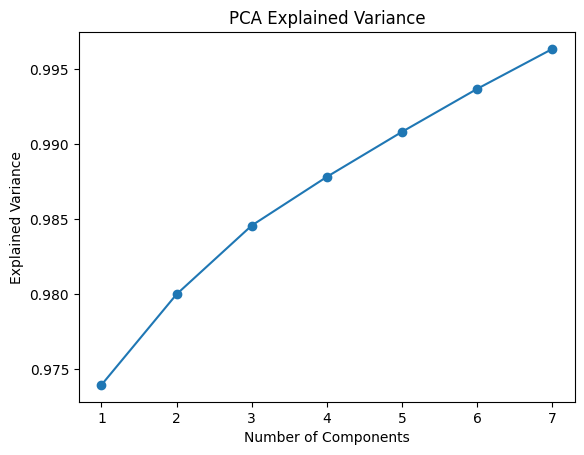

In [ ]:
# ¡No modificar! Gráfico de Varianza Explicada por Número de Componentes

explained_variance = []
for i in range(1, 8):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    explained_variance.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1, 8), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [ ]:
# Elige el número de componentes que consideres adecuado.

pca = PCA(n_components=5)

########################################################################################################################

# ¡No modificar! Esta celda se encarga de transformar los datos con PCA.

pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

In [ ]:
# Elige el modelo que deseas utilizar. Selecciona los hiperparámetros que consideres. ¿Elegiste la peor combinación anterior?
#     Ejemplo 1: model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE).
#     Ejemplo 2: model = KNeighborsClassifier(n_neighbors=10).

model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='brute',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=1
)

########################################################################################################################

# ¡No modificar! Este código se encarga de entrenar el modelo y mostrar los resultados en el set de validación.

model.fit(x_train_pca, y_train)

y_val_pca_pred = model.predict(x_val_pca)

print(f'[{model.__class__.__name__}] Validation Classification Report')
print(classification_report(y_val, y_val_pca_pred))

[KNeighborsClassifier] Validation Classification Report
              precision    recall  f1-score   support

        high       0.52      0.60      0.56      2649
         low       0.55      0.67      0.61      4490
      medium       0.38      0.21      0.27      3038

    accuracy                           0.51     10177
   macro avg       0.48      0.49      0.48     10177
weighted avg       0.49      0.51      0.49     10177



In [ ]:
# ¡No modificar! Esta celda se encarga de mostrar los resultados en el set de test.

y_test_pca_pred = model.predict(x_test_pca)

print(f'[{model.__class__.__name__}] Test Classification Report')
print(classification_report(y_test, y_test_pca_pred))

[KNeighborsClassifier] Test Classification Report
              precision    recall  f1-score   support

        high       0.50      0.60      0.55      3312
         low       0.56      0.66      0.61      5653
      medium       0.39      0.22      0.28      3757

    accuracy                           0.51     12722
   macro avg       0.48      0.49      0.48     12722
weighted avg       0.50      0.51      0.49     12722



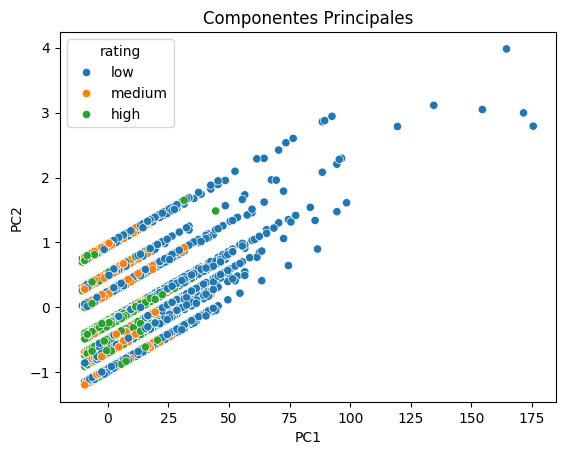

In [ ]:
df_train_pca = pd.DataFrame(
    x_train_pca,
    columns=[f'PC{i}' for i in range(1, x_train_pca.shape[1]+1)]
)
df_train_pca['rating'] = y_train.values
df_train_pca

sns.scatterplot(
    data=df_train_pca,
    x='PC1',
    y='PC2',
    hue='rating',
)
plt.title('Componentes Principales')
plt.show()

> # ¡NO OLVIDES GUARDAR Y SUBIR EL NOTEBOOK A LA PLATAFORMA CUANDO TERMINES! FORMATO .ipynb